### Configuración

Primero se cargan las librerías necesarias para el desarrollo del _notebook_

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from yaml import safe_load
from scipy.stats import uniform, binom, norm

Ahora se definen rutas relativas al _notebook_, para una adecuada manipulación de archivos dentro del directorio raíz.

In [2]:
# Ruta a directorio raíz
ROOT = os.path.dirname(os.getcwd())

# Abrir archivo de configuración
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as _file:
    CONFIG = safe_load(_file)
_file.close()

# 1. Cadenas de Markov vía Monte Carlo

Los métodos de Cadenas de Markov vía Monte Carlo (**MCMC**) son utilizados para **aproximar** la distribución posterior de un aplicación bajo enfoques Bayesianos.

Por ejemplo, en el clásico ejemplo de inferir la probabilidad $\theta$ de que una moneda resulte _Heads_ dado un conjunto de lanzamientos de la moneda, se pueden usar tres enfoques para conseguirlo:

* **Solución analítica**: La distribución inicial se especifica con una función conjugada con su verosimilitud, lo cual resulta en una distribución posterior que tiene solución analítica. Desafortunadamente, existen de pocas a nulas aplicaciones que se puedan resolver de esta manera.
* **Poblando el espacio parametral**: Conocemos el rango de valores que puede tomar el parámetro $\theta$, con lo que se puede especificar un _gridspace_ que abarque el espacio parametral. La desventaja de este enfoque es que rápidamente se vuelve dificil poblar el espacio a medida que incremente el número de parámetros, este problema es conocido como la **maldición de dimensionalidad**
* Cuando la aproximación mediante un _gridspace_ no es factible, entonces se utiizan los métodos MCMC

Estos métodos suponen que la distribución inicial está especificada por una función que fácilmente puede ser evaluada, es decir, dado un valor $\theta$ fácilmente se puede determinar $p(\theta)$. Esto resulta en una aproximación de la distribución posterior en la forma de un número grande de valores de $\theta$ muestreados aleatoriamente de la distribución.

¿Cómo se pueden generar muestras representativas de la posterior sin conocerla?

## 1.1. Algoritmo Metrópolis

Revisar la **sección 7.2.** del libro _Doing Bayesian Data Analyis_, J. Kruschke, 2° Edición.

### 1.1.1. Caminata Aleatoria

Supón que una persona vive en un sistema de islas consecutivas, constántemente viaja de una a otra, y al final del día debe decidir si se mueve a una nueva isla o no. Esto se puede representar en tres decisiones:
* Se queda en la isla en la que está actualmente,
* Se mueve a la isla a la derecha.
* Se mueve a la isla a la izquierda.

El objetivo es visitar las islas proporcionalmente a la población de cada una de ellas, pero el problema es que no sabe la población de cada isla, y desconoce a ciencia cierta cuántas islas hay. Sin embargo, a medida que pasa por cada isla tiene capacidad de:
* Preguntar la población de la isla en la que se encuentra.
* Cuando se propone una nueva isla por visitar, se puede preguntar la población de la nueva isla.

La heurística para decidir si se mueve o no es la siguiente:
1. Lanza un volado con una moneda justa para escojer la nueva isla (derecha o izquierda).
2. Si la nueva isla tiene una población más grande, se mueve sin dudar.
3. Si la nueva isla tiene menor población, entonces decide si moverse con criterios probabilísticos dados por:
    $$p_{mov}=\frac{P_{nueva}}{P_{actual}}$$
    
    En donde:
    * $P_{actual}$: Población de la isla actual.
    * $P_{nueva}$: Población de la isla propuesta.
    * $p_{mov}$: Probabilidad de moverse.
4. Luego gira una perinola con valores marcados uniformemente a lo largo de su circunferencia.
    * Si el valor de la perinola es menor a $p_{mov}$, se mueve.
    * Si el valor de la perinola es mayor $p_{mov}$, se queda en la isla actual.

### 1.1.2 Ejemplo de caminata aleatoria

Consideraciones del problema:
* Número de islas: 7
* Las islas están indexadas consecutivamente, la isla más a la izquierda es $\theta=1$, y la más a la derecha es $\theta=7$.
* La población relativa de las islas crece linealmente de modo que $P(\theta)=\theta$
* El viajero puede empezar en cualquier islar, pero esto lo desconoce.
* Existen 2 islas adicionales, una a la izquierda de la isla número 1 y otra a la derecha de la isla número 7, pero estas no tienen población.
* El viajero puede escoger moverse a estas islas, pero dado que no tienen población, siempre se quedará en la isla actual.

In [3]:
theta = np.arange(0,7,1)
p_theta = theta + 1
theta, p_theta

(array([0, 1, 2, 3, 4, 5, 6]), array([1, 2, 3, 4, 5, 6, 7]))

In [4]:
# Lanzar una moneda {0: izquierda, 1: derecha}
def escoger_direccion():
    casos = np.array([-1,1])
    volado = binom.rvs(n=1, p=0.5, loc=0, size=1)
    
    return casos[volado[0]]

In [5]:
# Parámetros de simulación
pos = 2
n_sims = 10_000
pasos = np.arange(1, n_sims+1, 1).reshape((-1,1))
pasos = np.hstack([pasos, np.zeros(shape=(n_sims, 1))])
pasos = np.vstack([np.array([0, pos]), pasos])

for iter in range(n_sims):
    direccion = escoger_direccion()

    # Control de isla extrema izquierda
    if pos == theta.min() and direccion == -1:
        pasos[iter+1, 1] = pos
    # Control de isla extrema derecha
    elif pos == theta.max() and direccion == 1:
        pasos[iter+1, 1] = pos
    
    else:
        # Evaluar poblaciones
        p_actual = p_theta[pos]
        p_nueva = p_theta[pos + direccion]
        p_mov = p_nueva / p_actual

        # Girar perinola
        perinola = uniform.rvs(size=1)[0]

        # Decidir si se mueve o no
        if p_nueva > p_actual:
            pos += direccion
        
        elif perinola < p_mov:
            pos += direccion

        # Almacenar posición en historia
        pasos[iter+1, 1] = pos

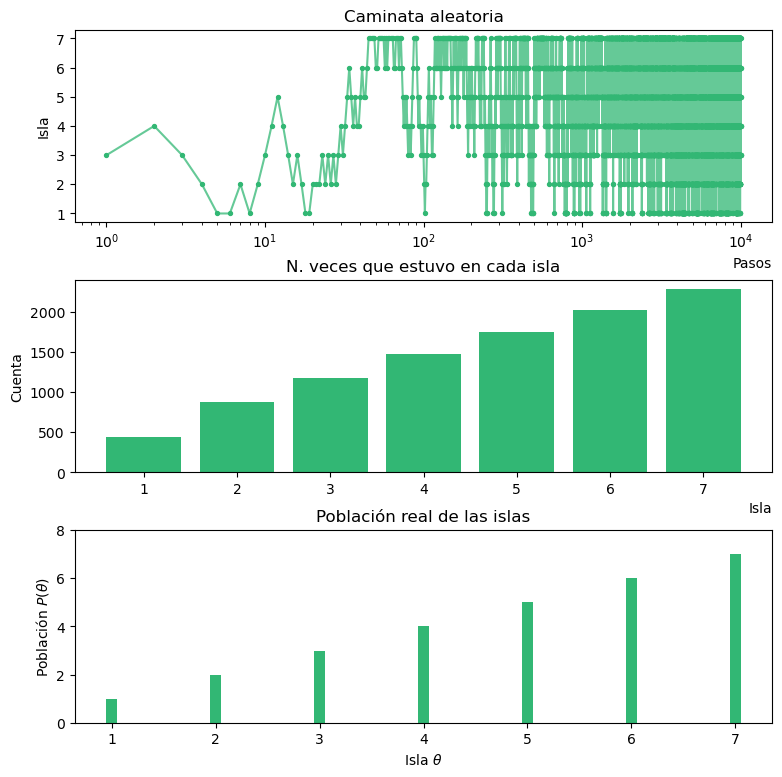

In [6]:
# Especificaciones de figura
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(9,9))
fig.subplots_adjust(hspace=0.3)

# Elementos de visualización
ax[0].plot(
    pasos[:,0]+1,
    pasos[:,1],
    color=CONFIG['graficas']['colors']['verde'],
    alpha=0.75)
ax[0].scatter(
    x=pasos[:,0]+1,
    y=pasos[:,1],
    s=8,
    color=CONFIG['graficas']['colors']['verde'])
ax[1].bar(
    x=np.unique(pasos[:,1], return_counts=True)[0],
    height=np.unique(pasos[:,1], return_counts=True)[1],
    color=CONFIG['graficas']['colors']['verde'])
ax[2].bar(
    x=theta+1,
    height=p_theta,
    width=0.1,
    color=CONFIG['graficas']['colors']['verde'])

# Anotaciones y estilo
ax[0].set_title('Caminata aleatoria')
ax[0].set_xlabel('Pasos', loc='right')
ax[0].set_ylabel('Isla')
ax[0].set_yticks(ticks=theta, labels=theta+1)
ax[0].set_xscale('log')

ax[1].set_title('N. veces que estuvo en cada isla')
ax[1].set_xlabel('Isla', loc='right')
ax[1].set_ylabel('Cuenta')
ax[1].set_xticks(ticks=theta, labels=theta+1)

ax[2].set_title('Población real de las islas')
ax[2].set_xlabel(r'Isla $\theta$')
ax[2].set_ylabel(r'Población $P(\theta)$')
ax[2].set_ylim(top=p_theta.max()+1)

plt.show()

Observa que después de un número grande de repeticiones, la frecuencia relativa del número de veces que se visitó cada isla **aproxima** bastante bien la distribución real de las poblaciones por isla.

# 1.2. Metrópolis para inicial Beta y verosimilitud Bernoulli

**Nota**: Apriori se sabe conjuga otra beta pero suponemos que eso no lo sabemos. En realidad no nos interesa conocer la forma exacta de la distribución posterior, per sí nos interesa poder generas muestras de ella para hacer inferencia sobre el parámetro de la Bernoulli.

Supón que se quiere hacer inferencia del parámetro $\theta$ en el lanzamiento de una moneda el cual se sabe tiene un espacio parametral $\theta\in(0,1)$. Hacemos $N$ lanzamientos y obtenemos $z$ _heads_. Dado el problema, se sabe que la verosimilitud de este queda dada por una función de verosimilitud Bernoulli:

$$p(z,N|\theta)=\theta^z\cdot(1-\theta)^{(N-z)}$$

Con algún experto en materia determinamos que nuestro estado de conocimiento inicial, o distribución inicial, puede representarse por una Beta:

$$p(\theta)=Beta(\theta|a,b)$$

Proponemos que los saltos con los cuales se explorará el espacio parametral se originen de una normal centrada en cero con desviación estandar $\sigma$, es decir:

$$\Delta\theta\sim Normal(\mu=0, \sigma)$$

La posición actual está definida por $\theta_{cur}$, con lo que la posición propuesta sera:

$$\theta_{pro}=\theta_{cur}+\Delta\theta$$

Los pasos para encontrar la distribución posterior de una inicial Beta con verosimilitud Bernoulli son los mismos que los de la caminata aleatoria:
* Empieza en una posición arbitraria y válida del espacio parametral.
* Genera aleatoriamente un salto $\Delta\theta$.
* Calcula la probabilidad de moverte a la posición propuesta.
    $$p_{move}=min\left(1, \frac{P(\theta_{pro})}{P(\theta_{cur})}\right)$$
    Por regla de Bayes, $P()$ es la verosimilitud por la inicial:
    $$p_{move}=min\left(1, \frac{p(D|\theta_{pro})\cdot p(\theta_{pro})}{p(D|\theta_{cur})\cdot p(\theta_{cur})}\right)$$
    Para el contexto de este problema:
    $$p_{move}=min\left(1, \frac{Ber(z,N|\theta_{pro})\cdot Beta(\theta_{pro}|a,b)}{Ber(z,N|\theta_{cur})\cdot Beta(\theta_{cur}|a,b)}\right)$$
    Reemplazando:
    $$p_{move}=min\left(1, \frac{\theta_{pro}^z\cdot(1-\theta_{pro})^{(N-z)}}{\theta_{cur}^z\cdot(1-\theta_{cur})^{(N-z)}}\cdot\frac{\theta_{pro}^{(a-1)}\cdot(1-\theta_{pro})^{(b-1)}/B(a,b)}{\theta_{cur}^{(a-1)}\cdot(1-\theta_{cur})^{(b-1)}/B(a,b)}\right)$$
    La constante de normalización se simplifica:
    $$p_{move}=min\left(1, \frac{\theta_{pro}^z\cdot(1-\theta_{pro})^{(N-z)}}{\theta_{cur}^z\cdot(1-\theta_{cur})^{(N-z)}}\cdot\frac{\theta_{pro}^{(a-1)}\cdot(1-\theta_{pro})^{(b-1)}}{\theta_{cur}^{(a-1)}\cdot(1-\theta_{cur})^{(b-1)}}\right)$$

* Acepta la posición propuesta comparando $p_{move}$ contra un valor muestreado de una uniforma [0,1]. Si este valor es menor que $p_{move}$ se acepta la nueva posición.
* Repite estos pasos un número grande de veces.

La implementación del algoritmo anterior se puede probar, por ejemplo, para el caso:
* Inicial $Beta(\theta|1,1)$, es decir, $a=1$, $b=1$
* $N=20$, lanzamientos de moneda
* $z=14$, lanzamiento resultantes en _heads_

In [7]:
# Función para proponer saltos
def simular_salto(sigma=0.2):
    salto = norm.rvs(loc=0, scale=sigma, size=1)
    return salto[0]

def prob_aceptacion(theta_cur, theta_pro, N, z, a, b):
    # Verosimilitudes
    verosim_pro = (theta_pro**z) * ((1 - theta_pro)**(N-z))
    verosim_cur = (theta_cur**z) * ((1 - theta_cur)**(N-z))

    # Iniciales
    inicial_pro = (theta_pro**(a-1)) * ((1 - theta_pro)**(b-1))
    inicial_cur = (theta_cur**(a-1)) * ((1 - theta_cur)**(b-1))

    # Probabilidad de aceptación
    p_move = (verosim_pro * inicial_pro) / (verosim_cur * inicial_cur)
    p_move = min(1, p_move)

    return p_move

In [8]:
# Parámetros del problema
N = 20
z = 14
a = b = 2
sigma = 0.25
n_sims = 50_000

# Posición inicial
theta_cur = 0.8

# Memoria de almacenamiento de simulaciones
pasos = np.arange(1, n_sims+1, 1).reshape((-1,1))
pasos = np.hstack([pasos, np.zeros(shape=(n_sims, 1))])
pasos = np.vstack([np.array([0, theta_cur]), pasos])

for iter in range(n_sims):
    # Simular salto
    salto = simular_salto(sigma=sigma)
    theta_pro = theta_cur + salto

    # Probabilidad de aceptación
    p_move = prob_aceptacion(
        theta_cur=theta_cur,
        theta_pro=theta_pro,
        N=N, z=z, a=a, b=b)

    # Criterio de aceptación/rechazo
    flag = uniform.rvs(size=1)[0]
    
    # Control de extremo izquierda
    if theta_pro < 0:
        pasos[iter+1, 1] = theta_cur
    # Control de extremo derecha
    elif theta_pro > 1:
        pasos[iter+1, 1] = theta_cur
    
    elif flag < p_move:
        pasos[iter+1, 1] = theta_pro
        theta_cur = theta_pro
    else:
        pasos[iter+1, 1] = theta_cur

# Promedios ergódicos
cum_sum = np.cumsum(pasos[:,1])
ergod_avg = cum_sum / (pasos[:,0] + 1)

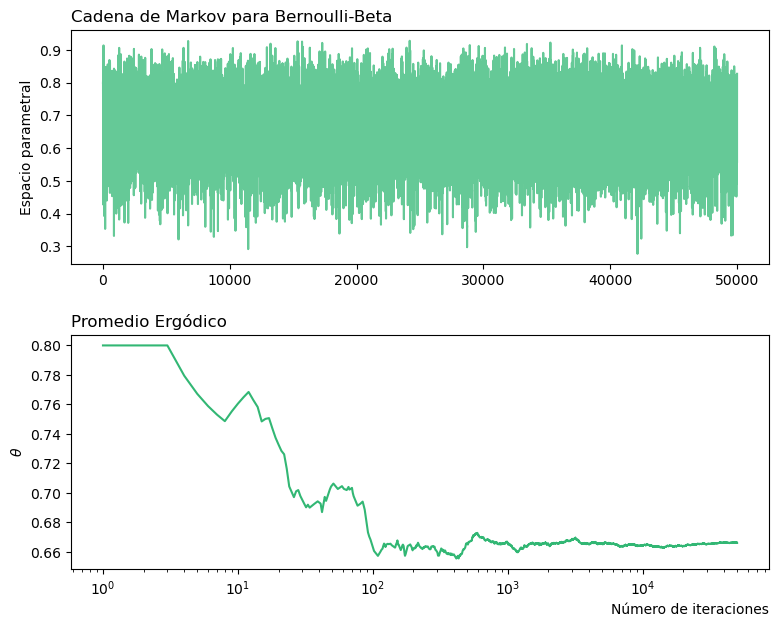

In [9]:
# Especificaciones de figura
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(9,7))
fig.subplots_adjust(hspace=0.3)

# Elementos de visualización
ax[0].plot(
    pasos[:,0]+1,
    pasos[:,1],
    CONFIG['graficas']['colors']['verde'],
    alpha=0.75)
ax[1].plot(
    pasos[:,0]+1,
    ergod_avg,
    CONFIG['graficas']['colors']['verde'])

# Anotaciones y estilo
ax[0].set_title('Cadena de Markov para Bernoulli-Beta', loc='left')
ax[0].set_ylabel(r'Espacio parametral')
#ax[0].set_xscale('log')

ax[1].set_title('Promedio Ergódico', loc='left')
ax[1].set_xlabel('Número de iteraciones', loc='right')
ax[1].set_ylabel(r'$\theta$')
ax[1].set_xscale('log')

plt.show()